# Solving TSP using machine learning

This Jupyter notebook is a simplified version of "<a href="https://github.com/chaitjo/learning-tsp">Learning TSP</a>" repo. It shows how to run pretrained models to solve different instances of TSP. For more information and for complete code including training, please see:
* <a href="https://github.com/chaitjo/learning-tsp">Learning TSP Requires Rethinking Generalization</a> Github repo.
* Chaitanya K. Joshi, Quentin Cappart, Louis-Martin Rousseau, Thomas Laurent, "<a href="https://arxiv.org/abs/2006.07054">Learning the Travelling Salesperson Problem Requires Rethinking Generalization</a>,"  27th International Conference on Principles and Practice of Constraint Programming (CP 2021).

### Imports necessary libraries and modules

These libraries provide functionalities for handling data, performing computations, visualization, and optimization.

In [1]:
import os
import math
import itertools
import numpy as np
import networkx as nx
from scipy.spatial.distance import pdist, squareform
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

import torch
from torch.utils.data import DataLoader
from torch.nn import DataParallel

from learning_tsp.problems.tsp.problem_tsp import TSP
from learning_tsp.utils import load_model, move_to

from gurobipy import *

warnings.filterwarnings("ignore", category=UserWarning)

### Sets environment variables

Set environment variables CUDA_DEVICE_ORDER and CUDA_VISIBLE_DEVICES to control the GPU device visibility.

In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = str(0)

### Defines opts class

This class contains several class-level attributes that define various options and configurations. 

In [3]:
class opts:
    dataset_path = "learning_tsp/data/tsp20-50_concorde.txt"
    batch_size = 16
    num_samples = 1280 
    
    neighbors = 0.20
    knn_strat = 'percentage'
    
    # model = "learning_tsp/pretrained/tsp_20-50/rl-ar-var-20pnn-gnn-max_20200313T002243"
    model = "learning_tsp/pretrained/tspsl_20-50/sl-ar-var-20pnn-gnn-max_20200308T172931"
    
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda:0" if use_cuda else "cpu")

### Creates the dataset and dataloader

Create a TSP dataset by calling the TSP.make_dataset() function with the specified dataset path (opts.dataset_path) and other parameters. It then creates a DataLoader object (dataloader) to iterate over the dataset in batches during training or evaluation.

The code sets up the necessary environment, loads the model, and prepares the dataset and dataloader for subsequent processing, such as performing inference or training on the TSP problem.

In [4]:
dataset = TSP.make_dataset(
    filename=opts.dataset_path, batch_size=opts.batch_size, num_samples=opts.num_samples, 
    neighbors=opts.neighbors, knn_strat=opts.knn_strat, supervised=True
)
dataloader = DataLoader(dataset, batch_size=opts.batch_size, shuffle=False, num_workers=0)


Loading from learning_tsp/data/tsp20-50_concorde.txt...


100%|##########| 1280/1280 [00:00<00:00, 4266.68it/s]


### Load pretrained model

Load the trained model and assign the loaded model to the variable model. If the model is wrapped in torch.nn.DataParallel, it extracts the underlying module by accessing model.module.

Set the decoding type of the model to "greedy" and set the model's mode to evaluation using model.eval(), which ensures that the model is in inference mode and not training mode.

In [5]:
model, model_args = load_model(opts.model, extra_logging=True)
model.to(opts.device)

if isinstance(model, DataParallel):
    model = model.module
model.set_decode_type("greedy")

model.eval()


Loading model from learning_tsp/pretrained/tspsl_20-50/sl-ar-var-20pnn-gnn-max_20200308T172931\epoch-9.pt


AttentionModel(
  (init_embed): Linear(in_features=2, out_features=128, bias=True)
  (embedder): GNNEncoder(
    (init_embed_edges): Embedding(2, 128)
    (layers): ModuleList(
      (0): GNNLayer(
        (U): Linear(in_features=128, out_features=128, bias=True)
        (V): Linear(in_features=128, out_features=128, bias=True)
        (A): Linear(in_features=128, out_features=128, bias=True)
        (B): Linear(in_features=128, out_features=128, bias=True)
        (C): Linear(in_features=128, out_features=128, bias=True)
        (norm_h): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (norm_e): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      )
      (1): GNNLayer(
        (U): Linear(in_features=128, out_features=128, bias=True)
        (V): Linear(in_features=128, out_features=128, bias=True)
        (A): Linear(in_features=128, out_features=128, bias=True)
        (B): Linear(in_features=128, out_feat

### Plot TSP tours

This helper function takes a Matplotlib figure/subplot (p), coordinates of nodes (x_coord), the predicted tour (tour), and an optional title. It uses NetworkX to create a graph, assigns positions to nodes, and plots nodes and edges based on the provided information.

Arguments:
* p: Matplotlib figure/subplot
* x_coord: Coordinates of nodes
* tour: Predicted tour
* title: Title of figure/subplot

Returns:
* p: Updated figure/subplot

In [6]:
def plot_tsp(p, x_coord, tour, title="default"):

    W_val = squareform(pdist(x_coord, metric='euclidean'))
    G = nx.from_numpy_matrix(W_val)
    
    pos = dict(zip(range(len(x_coord)), x_coord.tolist()))
    
    tour_pairs = []
    for idx in range(len(tour)-1):
        tour_pairs.append((tour[idx], tour[idx+1]))
    tour_pairs.append((tour[idx+1], tour[0]))
    
    nx.draw_networkx_nodes(G, pos, node_color='b', node_size=30)
    nx.draw_networkx_edges(G, pos, edgelist=tour_pairs, edge_color='black', alpha=1, width=1)
    p.set_title(title)
    return p

### Plot predicted TSP tours with edge strength denoting confidence of prediction.

This function plots predicted TSP tours with edge strength denoting the confidence of the prediction. It takes a Matplotlib figure/subplot (p), coordinates of nodes (x_coord), an edge predictions matrix (W_pred), a threshold for edge probability, and an optional title. It uses NetworkX to create a graph, assigns positions to nodes, and plots nodes and edges based on the provided information. Edges above the threshold are displayed with varying edge colors.

Arguments:
* p: Matplotlib figure/subplot
* x_coord: Coordinates of nodes
* W_pred: Edge predictions matrix
* threshold: Threshold above which edge predicion probabilities are plotted
* title: Title of figure/subplot

Returns:
* p

In [7]:
def plot_tsp_heatmap(p, x_coord, W_pred, threshold=0.1, title="default"):
    W_val = squareform(pdist(x_coord, metric='euclidean'))
    G = nx.from_numpy_matrix(W_val)
    
    pos = dict(zip(range(len(x_coord)), x_coord.tolist()))    
    
    edge_pairs = []
    edge_color = []
    for r in range(len(W_pred)):
        for c in range(len(W_pred)):
            if W_pred[r][c] >= threshold:
                edge_pairs.append((r, c))
                edge_color.append(W_pred[r][c])
    
    nx.draw_networkx_nodes(G, pos, node_color='b', node_size=30)
    nx.draw_networkx_edges(G, pos, edgelist=edge_pairs, edge_color=edge_color, edge_cmap=plt.cm.Reds, width=1)
    p.set_title(title)
    return p

### Plot predicted TSP tours with edge strength denoting confidence of prediction

 This function plots predicted TSP tours with edge strength denoting the confidence of the prediction. It takes a Matplotlib figure/subplot (p), coordinates of nodes (x_coord), edge reduce costs (rcs), a threshold for reduce costs, and an optional title. It uses NetworkX to create a graph, assigns positions to nodes, and plots nodes and edges based on the provided information. Edges below the threshold are displayed with varying edge colors.

Arguments:
* p: Matplotlib figure/subplot
* x_coord: Coordinates of nodes
* rcs: Reduce costs of edges
* threshold: Threshold below which edge reduce costs are plotted
* title: Title of figure/subplot

Returns:
* p: Updated figure/subplot

In [8]:
def plot_tsp_rcs(p, x_coord, rcs, threshold=0.5, title="default"):
    W_val = squareform(pdist(x_coord, metric='euclidean'))
    G = nx.from_numpy_matrix(W_val)
    
    pos = dict(zip(range(len(x_coord)), x_coord.tolist()))    
    
    edge_pairs = []
    edge_color = []
    for r in range(len(rcs)):
        for c in range(len(rcs)):
            if rcs[r][c] <= threshold:
                edge_pairs.append((r, c))
                edge_color.append(1 - rcs[r][c])
    
    nx.draw_networkx_nodes(G, pos, node_color='b', node_size=30)
    nx.draw_networkx_edges(G, pos, edgelist=edge_pairs, edge_color=edge_color, edge_cmap=plt.cm.Reds, width=1)
    p.set_title(title)
    return p

### Gurobi callback used to eliminate sub-tours during optimization

This function is a Gurobi callback used to eliminate sub-tours during optimization. It is called when a feasible integer solution is found. If the solution contains sub-tours, it adds constraints to the model to eliminate those sub-tours.

In [9]:
def subtourelim(model, where):
    # Callback - use lazy constraints to eliminate sub-tours
    
    if where == GRB.Callback.MIPSOL:
        # make a list of edges selected in the solution
        vals = model.cbGetSolution(model._vars)
        selected = tuplelist((i,j) for i,j in model._vars.keys() if vals[i,j] > 0.5)
        # find the shortest cycle in the selected edge list
        tour = subtour(selected)
        if len(tour) < n:
            # add subtour elimination constraint for every pair of cities in tour
            model.cbLazy(quicksum(model._vars[i,j]
                                  for i,j in itertools.combinations(tour, 2))
                         <= len(tour)-1)

### Find the shortest subtour

This function finds the shortest subtour given a tuple list of edges.

In [10]:
def subtour(edges):   
    unvisited = list(range(n))
    cycle = range(n+1) # initial length has 1 more city
    while unvisited: # true if list is non-empty
        thiscycle = []
        neighbors = unvisited
        while neighbors:
            current = neighbors[0]
            thiscycle.append(current)
            unvisited.remove(current)
            neighbors = [j for i,j in edges.select(current,'*') if j in unvisited]
        if len(cycle) > len(thiscycle):
            cycle = thiscycle
    return cycle

### Calculate the reduce costs for a set of points using the Gurobi optimization library.

This function constructs a distance matrix (dist), creates variables, adds degree-2 constraints, and optimizes the model to obtain the reduce costs.

In [11]:
def get_reduce_costs(points):
    n = len(points)
    
    dist = {
        (i,j) : math.sqrt(sum((points[i][k] - points[j][k])**2 for k in range(2)))
            for i in range(n) for j in range(i)
    }

    m = Model()
    m.setParam('OutputFlag', 0)

    # Create variables
    vars = m.addVars(dist.keys(), obj=dist, vtype=GRB.CONTINUOUS, name='e')
    for i,j in vars.keys():
        vars[j,i] = vars[i,j] # edge in opposite direction

    # Add degree-2 constraint
    m.addConstrs(vars.sum(i,'*') == 2 for i in range(n))

    # Optimize model
    m._vars = vars
    m.Params.lazyConstraints = 1
    m.optimize(subtourelim)

    reduce_costs = np.zeros((len(points), len(points)))
    
    for i, j in dist.keys():
        reduce_costs[i][j] = vars[i,j].RC
        reduce_costs[j][i] = vars[i,j].RC
    
    return reduce_costs

### log probability and predicted tour to heatmap

This function converts the log probability and predicted tour (pi) into a heatmap, where each node's log probability is assigned to its corresponding position.

In [12]:
def log_p_to_heatmap(log_p, pi):
    heatmap = np.zeros(log_p.shape)
    heatmap[pi[-1]] = log_p[0]
    for cur_node, next_pred in zip(pi[:-1], log_p[1:]):
        heatmap[cur_node] = next_pred
    return heatmap

### Normalizes distance

This function normalizes distance values by dividing them by the maximum distance in the matrix.

In [13]:
def normalize_dists(dists):
    return dists / dists.max()

### Generate visualization


The code then includes a loop that iterates over the dataloader, which contains TSP instances. Within the loop, it performs the following steps:
* Checks if the size of the TSP instance has changed since the previous iteration.
* If the size has changed, it displays information about the TSP instance and creates a figure for visualization.
* It calls the helper functions to plot the TSP tour, reduce costs, prediction heatmap, and greedy solution.
* It displays the figure with the visualizations.
* It creates another figure to display heatmaps of Euclidean distance, reduce costs, and (1 - Model Predictions).
* It displays the figure with the heatmaps.
* Updates the previous size variable.

This loop iterates through the TSP instances, calculates various values related to the TSP problem, and generates visualizations for analysis and evaluation purposes.

################################################################################

TSP44

Restricted license - for non-production use only - expires 2024-10-28


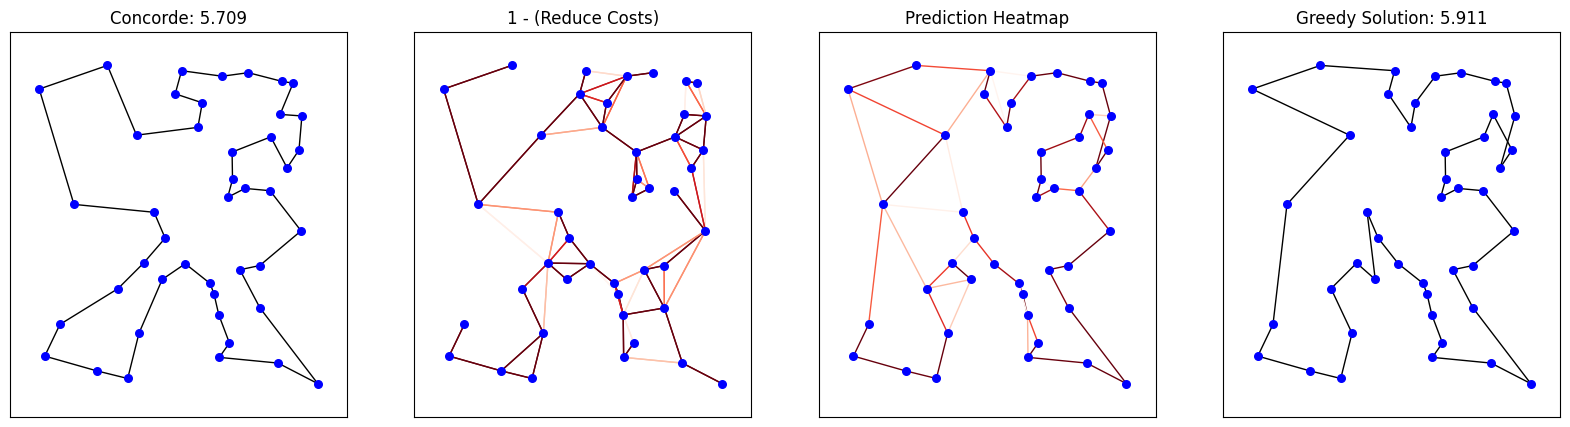

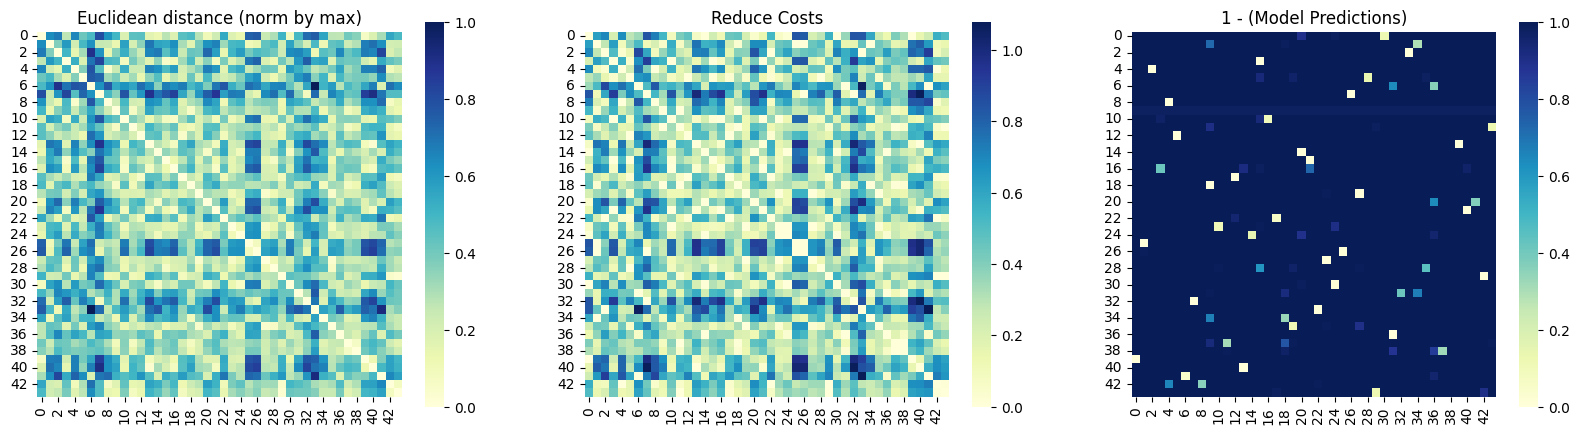

################################################################################

TSP50



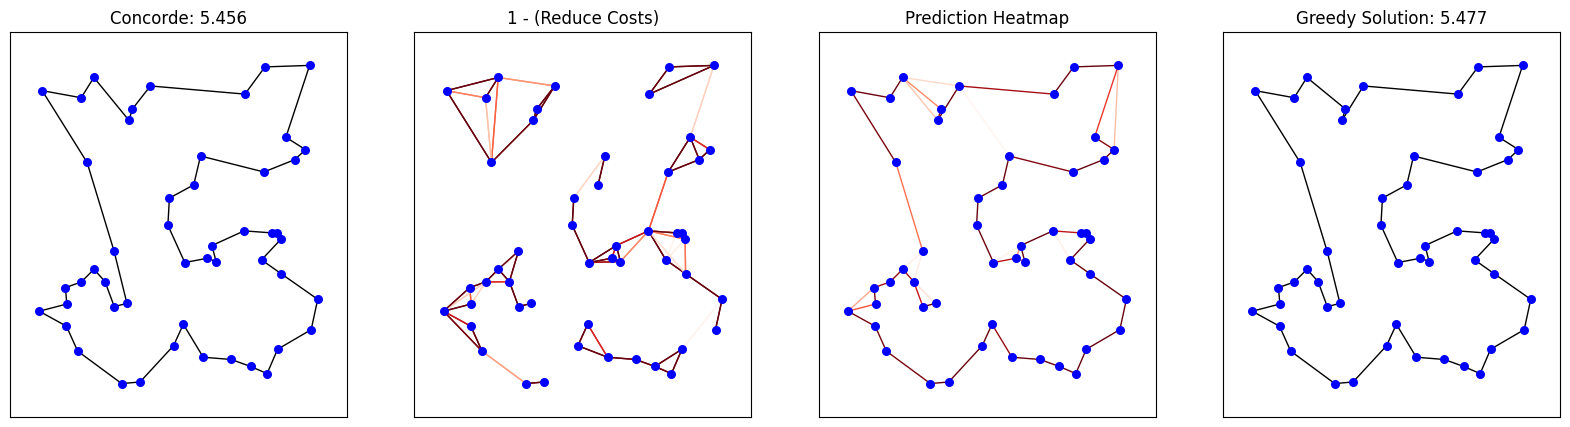

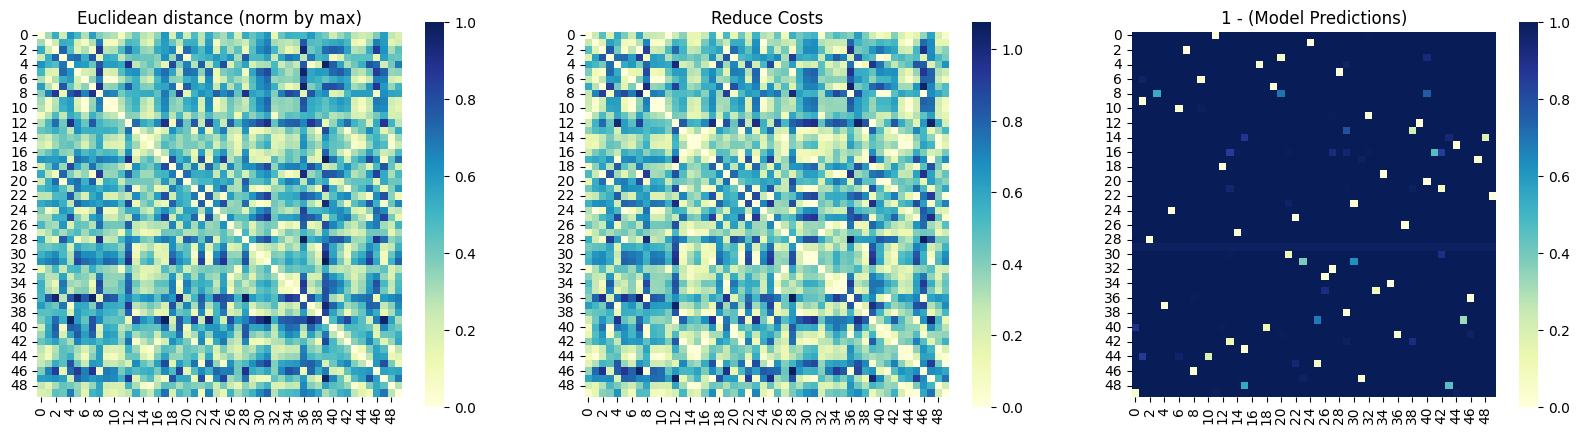

################################################################################

TSP24



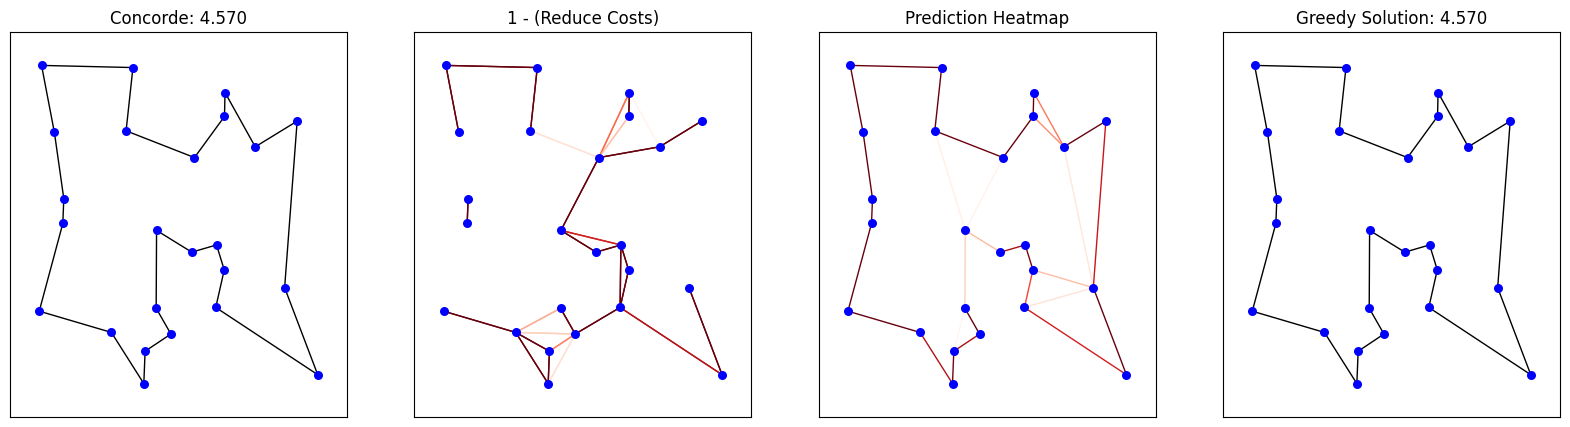

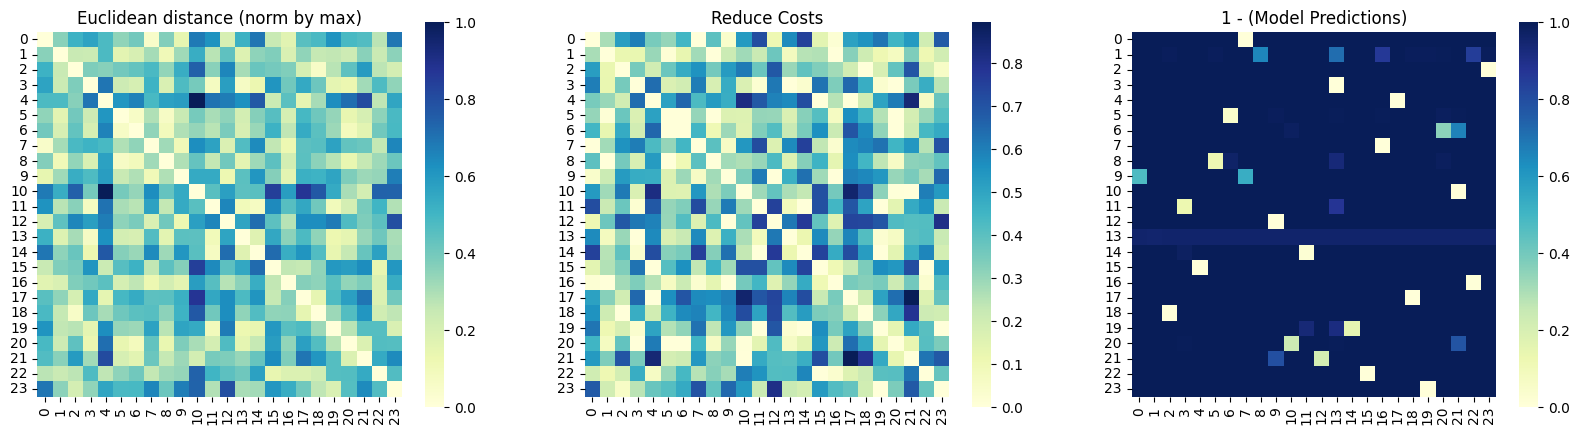

################################################################################

TSP48



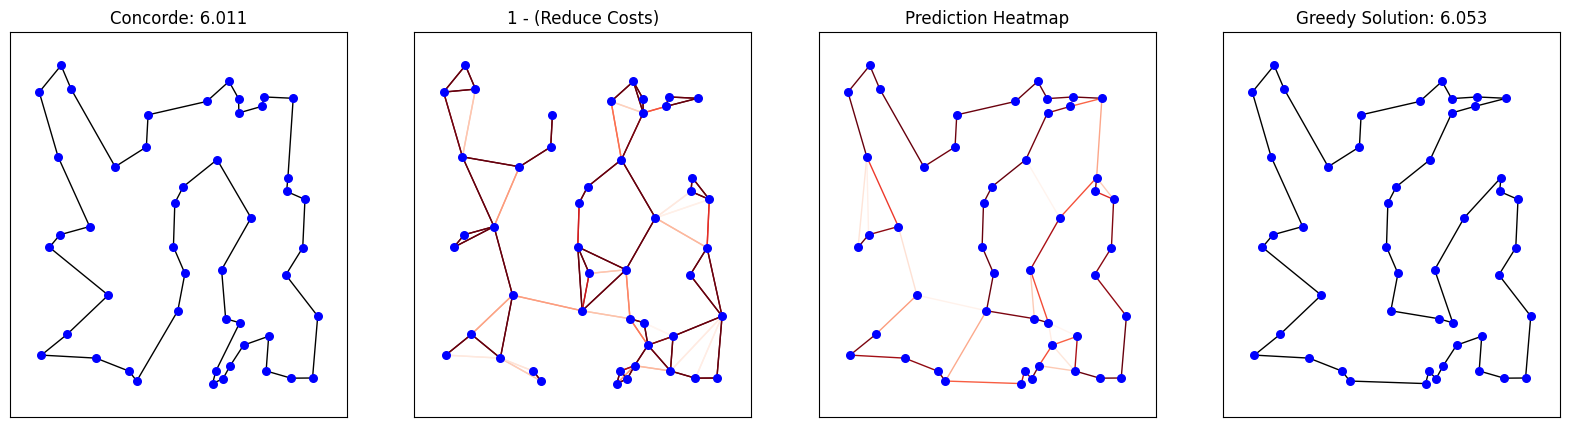

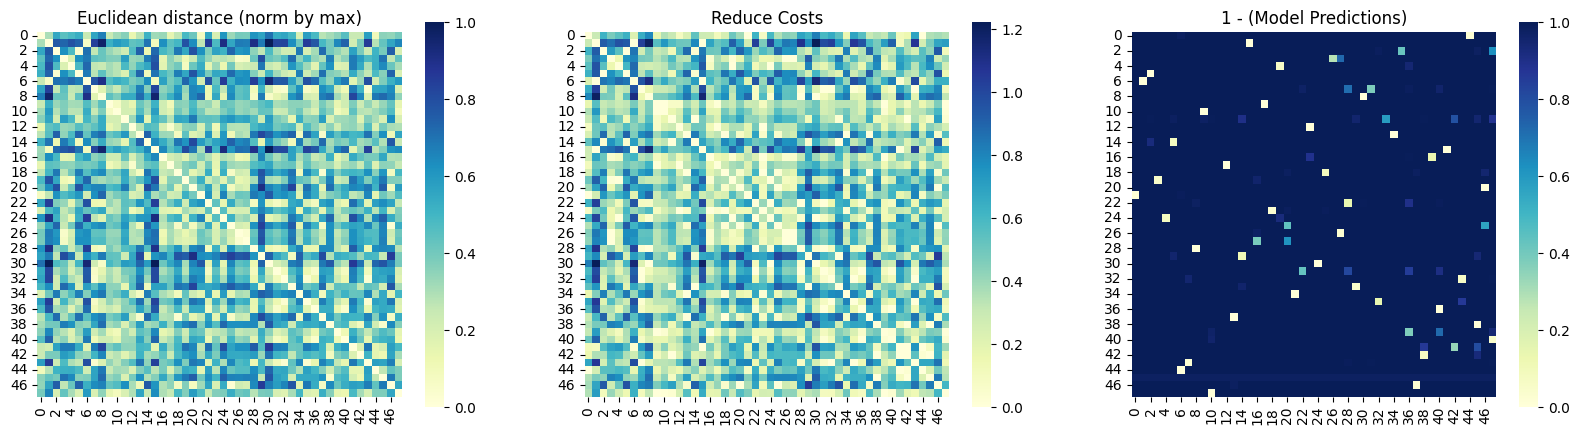

################################################################################

TSP29



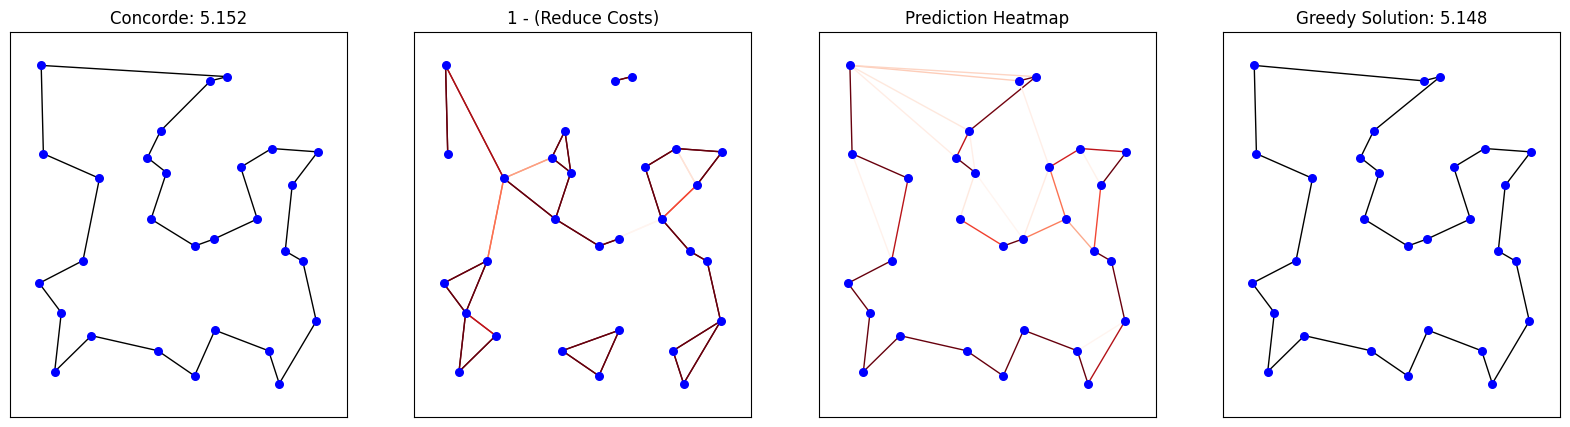

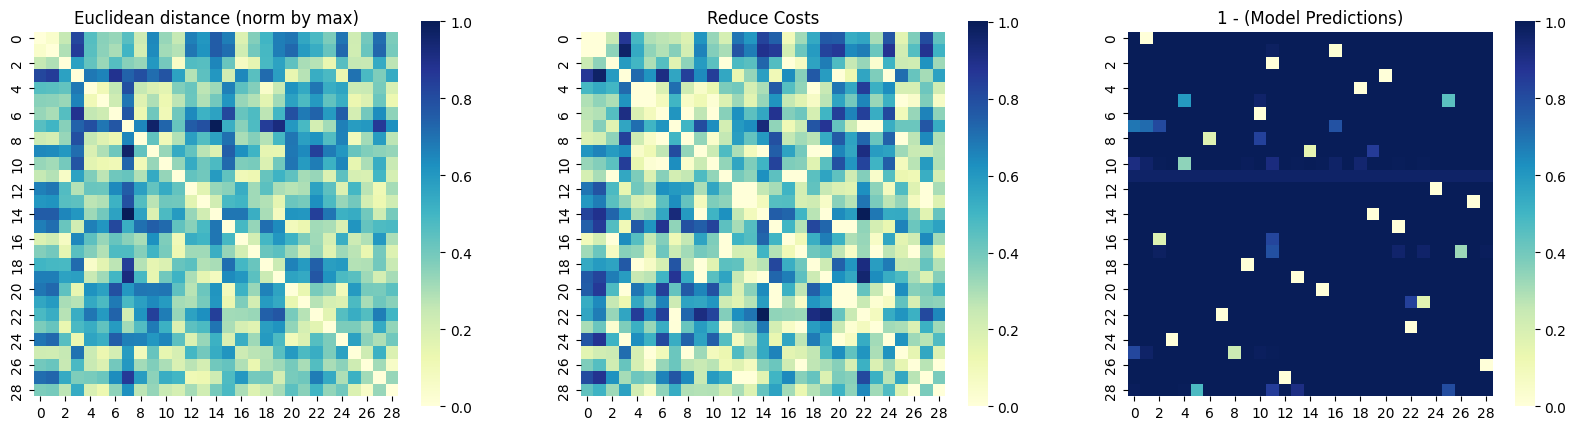

In [14]:
plot_idx = 1
prev_size = 0

torch.tensor([]).masked_fill(torch.tensor([]), 0)  # Trigger the warning once to disable it


with torch.no_grad():

    for bat_idx, bat in enumerate(dataloader):
        
        if bat['nodes'].shape[1] > prev_size:
            
            print(80*"#")
            print(f"\nTSP{bat['nodes'].shape[1]}\n")
            
            x = move_to(bat['nodes'], opts.device)
            graph = move_to(bat['graph'], opts.device)
            tour_nodes = move_to(bat['tour_nodes'], opts.device)

            cost, ll, pi = model(x, graph, return_pi=True)
            gt_cost, _ = TSP.get_costs(x, tour_nodes)
            
            f = plt.figure(0, figsize=(20, 5))
            
            p1 = f.add_subplot(141)
            plot_tsp(
                p1, 
                x[plot_idx].cpu().numpy(), 
                tour_nodes[plot_idx].cpu().numpy(), 
                title=f"Concorde: {gt_cost[plot_idx].cpu().numpy():.3f}"
            )
            
            p2 = f.add_subplot(142)
            plot_tsp_rcs(
                p2, 
                x[plot_idx].cpu().numpy(), 
                get_reduce_costs(x[plot_idx].cpu().numpy()), 
                threshold=0.05,
                title="1 - (Reduce Costs)"
            )
            
            p3 = f.add_subplot(143)
            plot_tsp_heatmap(
                p3, 
                x[plot_idx].cpu().numpy(), 
                log_p_to_heatmap(
                    np.exp(model.log_p_batch[plot_idx].cpu().numpy()), 
                    pi[plot_idx].cpu().numpy()
                ), 
                threshold=0.1,
                title="Prediction Heatmap"
            )
            
            p4 = f.add_subplot(144)
            plot_tsp(
                p4, 
                x[plot_idx].cpu().numpy(), 
                pi[plot_idx].cpu().numpy(), 
                title=f"Greedy Solution: {cost[plot_idx].cpu().numpy():.3f}"
            )
            
            plt.show()
            
            f = plt.figure(0, figsize=(20, 5))
            
            p1 = f.add_subplot(131)
            sns.heatmap(
                normalize_dists(
                    squareform(pdist(x[plot_idx].cpu().numpy(), metric='euclidean'))
                ),
                cmap="YlGnBu",
                ax=p1,
                square=True
            ).set_title("Euclidean distance (norm by max)")
            
            p2 = f.add_subplot(132)
            sns.heatmap(
                get_reduce_costs(x[plot_idx].cpu().numpy()),
                cmap="YlGnBu",
                ax=p2,
                square=True
            ).set_title("Reduce Costs")
            
            p3 = f.add_subplot(133)
            sns.heatmap(
                1 - log_p_to_heatmap(np.exp(model.log_p_batch[plot_idx].cpu().numpy()), pi[plot_idx].cpu().numpy()),
                cmap="YlGnBu",
                ax=p3,
                square=True
            ).set_title("1 - (Model Predictions)")
            
            plt.show()
            
        prev_size = bat['nodes'].shape[1]